In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from glob import glob

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "DejaVu Sans")
plt.rcParams["axes.unicode_minus"] = False

In [45]:
def load_images_and_labels(files, label, size):
    images = [image.load_img(p, target_size=(size, size)) for p in files]  # warping
    labels = [label] * len(files)
    print(files)
    return images, labels

In [46]:
man_file= glob('../data/imgs/data_mw/man/*jpg')
wom_file= glob('../data/imgs/data_mw/woman/*jpg')

man_file_224_x, man_file_224_y = load_images_and_labels(man_file, 0, 224)
wom_file_224_x, wom_file_224_y = load_images_and_labels(wom_file, 1, 224)

from tensorflow.keras.utils import to_categorical

images_224 = man_file_224_x + wom_file_224_x
labels = man_file_224_y + wom_file_224_y
labels = to_categorical(labels)
vector_224 = np.asarray([image.img_to_array(img) for img in images_224])

x_train, x_test, y_train, y_test = train_test_split(vector_224, labels, random_state=42, test_size=0.2)

['../data/imgs/data_mw/man/ma_194.jpg', '../data/imgs/data_mw/man/ma_44.jpg', '../data/imgs/data_mw/man/ma_117.jpg', '../data/imgs/data_mw/man/ma_77.jpg', '../data/imgs/data_mw/man/ma_165.jpg', '../data/imgs/data_mw/man/ma_163.jpg', '../data/imgs/data_mw/man/ma_119.jpg', '../data/imgs/data_mw/man/ma_26.jpg', '../data/imgs/data_mw/man/ma_50.jpg', '../data/imgs/data_mw/man/ma_144.jpg', '../data/imgs/data_mw/man/ma_99.jpg', '../data/imgs/data_mw/man/ma_19.jpg', '../data/imgs/data_mw/man/ma_9.jpg', '../data/imgs/data_mw/man/ma_147.jpg', '../data/imgs/data_mw/man/ma_171.jpg', '../data/imgs/data_mw/man/ma_88.jpg', '../data/imgs/data_mw/man/ma_94.jpg', '../data/imgs/data_mw/man/ma_100.jpg', '../data/imgs/data_mw/man/ma_8.jpg', '../data/imgs/data_mw/man/ma_71.jpg', '../data/imgs/data_mw/man/ma_55.jpg', '../data/imgs/data_mw/man/ma_49.jpg', '../data/imgs/data_mw/man/ma_39.jpg', '../data/imgs/data_mw/man/ma_157.jpg', '../data/imgs/data_mw/man/ma_60.jpg', '../data/imgs/data_mw/man/ma_185.jpg', '.

### TEST 데이터로 확인하기

In [47]:
### train data 증강하기
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False)

train_augmented_images = train_datagen.flow(x_train, y_train,
                                            shuffle=True,
                                            batch_size=64)

### test 안 증강
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_augmented_images = test_datagen.flow(x_test, y_test,
                                            shuffle=True,
                                            batch_size=64)

In [48]:
def load_images_and_labels(files, label, size):
    images = [image.load_img(p, target_size=(size, size)) for p in files]  # warping
    labels = [label] * len(files)
    print(files)
    return images, labels

### 모바일 넷 정답라벨

In [49]:
# 라벨 파일 URL
LABEL_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'

# 라벨 파일 다운로드 및 읽기
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', LABEL_URL)
with open(labels_path) as f:
    labels = f.readlines()

labels = [label.strip() for label in labels][1:]

### 모델 결과 비교

In [91]:

trans_model = tf.keras.models.load_model('2_2_transfer_final_model.keras')
finet_model = tf.keras.models.load_model('3_2_fine_tuning_final_model.keras')
scrat_model = tf.keras.models.load_model('4_1_from_scratch.keras')

base_model = MobileNet(include_top=True, input_shape=(224,224,3), weights='imagenet')

In [99]:
mw_label = {0:"남자", 1:"여자"}


정답 : 여자

    베이스 라인 모델 예측 : fur coat
    전이 학습 모델 예측 : 여자
    파인 튜닝 모델 예측 : 여자
    직접 구축 모델 예측 : 남자    


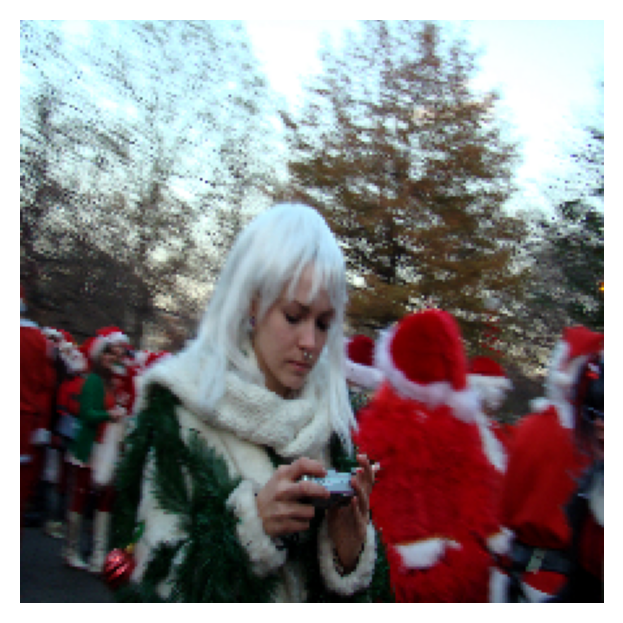

In [163]:
fig, ax = plt.subplots(figsize=(15,3))

for j in np.random.randint(1,64,1):

    print('\n정답 : ',end='')
    if test_augmented_images[0][1][j][0] == 1:
        print('남자',end='')
    else:
        print('여자', end='\n')
    
    ax.imshow((test_augmented_images[0][0][j]+1)/2);
    ax.grid(False)
    ax.set_axis_off()

    print(f'''
    베이스 라인 모델 예측 : {labels[base_model.predict(test_augmented_images[0][0][j].reshape(1,224,224,3), verbose=0).argmax()].__str__().strip()}
    전이 학습 모델 예측 : {mw_label[trans_model.predict(test_augmented_images[0][0][j].reshape(1,224,224,3), verbose=0).argmax()].__str__().strip()}
    파인 튜닝 모델 예측 : {mw_label[finet_model.predict(test_augmented_images[0][0][j].reshape(1,224,224,3), verbose=0).argmax()].__str__().strip()}
    직접 구축 모델 예측 : {mw_label[scrat_model.predict(test_augmented_images[0][0][j].reshape(1,224,224,3), verbose=0).argmax()].__str__().strip()}\
    ''', end='\n')